# Modeling

In this notebook I take what I learned from the exploratory data analysis and feature engineering stages and use it to help me build machine learning models capable of classifying a transaction as normal or fraudulent. I will first import the data and engineer it. Then I will try out several machine learning models including logistic regression, decision tree, random forest, and K-nearest-neighbors. Along the way I will look at the feature importances to see if I need to make any changes to the engineering process. The modeling process will not include scaling, as the data is most likely already scaled since the source noted the features are a product of principal component analysis. The process will however, include grid searches to hone in on the best hyper-parameters for the models. As for performance metrics, I will use f1-score for the grid search, but my main goal is high recall. The higher the recall score the fewer frauds go undetected. Recall must be balanced with precision, which is equal to the amount of true positives divided by the sum of the amount of true positives and false negatives. essentially the inverse of the rate the model falsely flags normal transactions as fraudulent. My goal is to have recall as high as possible with precision above %20. With the data being only %0.2 frauds, this will mean that I incorrectly flag a transaction as fraud %0.08 of the time.

### Road Map
1) Engineer Data <br>
2) Go Through Each Type of Model I Stated<br>
3) Examine Results For Each Model<br>

In [2]:
# import libraries

# standard scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# train-test split for validation set
from sklearn.model_selection import StratifiedShuffleSplit

# file storage
import pickle

# import the custom functions I created in feature engineering
from custom_functions import slice_feats, resample_data, slice_resample_data

# Principal component analysis
from sklearn.decomposition import PCA

# machine learning models
# linear
from sklearn.linear_model import LogisticRegression
# tree
from sklearn.tree import DecisionTreeClassifier
# ensemble
from sklearn.ensemble import RandomForestClassifier
# distance
from sklearn.neighbors import KNeighborsClassifier

# performance metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# grid search
from sklearn.model_selection import GridSearchCV

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\zasz\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\zasz\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# create a validation set using stratified shuffle split

# instantiate stratified shuffle split
sss = StratifiedShuffleSplit(test_size=0.1)

# seperate X and y
X = train.drop("Class", axis=1)
y = train.Class

# find indices
train_indices, val_indices = next(sss.split(X, y))

# create validation set
val = train.iloc[val_indices]
train = train.iloc[train_indices]


# preview value counts
val.Class.value_counts(normalize=True)

0    0.998341
1    0.001659
Name: Class, dtype: float64

In [4]:
train.Class.value_counts(normalize=True)

0    0.998332
1    0.001668
Name: Class, dtype: float64

# 1. Engineer Data

Now I will engineer the data as I did in the feature engineering stage. I will create two sets of data, one for linear models, and another for tree based models. Although I will try both sets out on each model. The process involves slicing the data down to a smaller amount of features, resampling the data with the NearMiss algorithm, and for the linear models I will perform Principal Component Analysis.

In [5]:
# import lists of ideal features which were deturmined
# in the feature engineering stage
with open("feature_engineering_notes.pickle", "rb") as file:
    notes = pickle.load(file)
    
notes

{'linear': ['V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'],
 'tree': ['V11', 'V12', 'V14', 'V16', 'V18']}

In [6]:
# slice and resample data. once for each set:
# linear, tree, and linear w/ PCA
lin_X_train, lin_y_train = slice_resample_data(train, notes["linear"])
tree_X_train, tree_y_train = slice_resample_data(train, notes["tree"])

# also set up test and validation data by slicing
lin_X_val, lin_y_val = slice_feats(val, notes["linear"])
lin_X_test, lin_y_test = slice_feats(test, notes["linear"])

tree_X_val, tree_y_val = slice_feats(val, notes["tree"])
tree_X_test, tree_y_test = slice_feats(test, notes["tree"])

Using TensorFlow backend.


In [7]:
# perform principal component analysis on
# the linear data.
# make sure to fit to training data and
# not to fit to validation and testing data
pca = PCA(n_components=3)
lin_pca_X_train = pca.fit_transform(lin_X_train)
lin_pca_X_val = pca.transform(lin_X_val)
lin_pca_X_test = pca.transform(lin_X_test)

In [31]:
# put data into a dictionary to help with automation
data = {}

# linear data
data["lin"] = {
    "X_train":lin_X_train,
    "y_train":lin_y_train,
    "X_val":lin_X_val,
    "y_val":lin_y_val,
    "X_test":lin_X_test,
    "y_test":lin_y_test
}

# tree data
data["tree"] = {
    "X_train":tree_X_train,
    "y_train":tree_y_train,
    "X_val":tree_X_val,
    "y_val":tree_y_val,
    "X_test":tree_X_test,
    "y_test":tree_y_test
}

# linear data w/ PCA
data["lin_pca"] = {
    "X_train":lin_pca_X_train,
    "y_train":lin_y_train,
    "X_val":lin_pca_X_val,
    "y_val":lin_y_val,
    "X_test":lin_pca_X_test,
    "y_test":lin_y_test
}

data["original"] = {
    "X_train":train.drop("Class", axis=1),
    "y_train":train.Class,
    "X_val":val.drop("Class", axis=1),
    "y_val":val.Class,
    "X_test":test.drop("Class", axis=1),
    "y_test":test.Class
}

# 2. Go Through Each Type of Model

For each model I will try out all three types of data (data for linear models, data for tree models, and PCA transformed data for linear models). I will also conduct grid searches to find the optimal hyperparameters for the models.  Finally for each model I will examine the results and see if anything can be improved. <br><br>
Again the models I will experiment with are:<br>
1) Logistic Regression <br>
2) Decision Tree<br>
3) Random Forest<br>
4) K-Nearest-Neighbors<br>

## 2.1 Logistic Regression

Logistic Regression works by setting a coefficient for each feature along with a bias (Much like slope and y intercept). It then takes a logorithm to calculate a probability. It then labels the prediction as either 1 or 0 depending on whether the probability meets a certain threshold (default threshold is 0.5). This algorithm is very simple and rather robust to overfitting. The only hyperparameter I will be tuning is the "C" value, which is the inverse of the learning rate (a value that deturmines how fast the coefficients are tuned).

In [43]:
# create a function for performing a 
# grid search on each type of data
def automated_grid_search(clf, params):
    
    # iterate over each type of data
    for key in ["lin", "lin_pca", "tree"]:
        
        # fit and predict using a grid search object
        
        # instantiate grid search with classifier and paramater grid
        gscv = GridSearchCV(clf, params, scoring="f1")
        
        # fit
        gscv.fit(data[key]["X_train"], data[key]["y_train"])

        # print key
        print("\n\n", key, "\n\n")
        
        # print training f1-score
        print(f"Training F1-Score: {gscv.best_score_}")
        
                
        # predict
        predictions = gscv.predict(data[key]["X_val"])
        
        # print validation f1-score
        score = f1_score(data[key]["y_val"], predictions)
        print(f"Validation F1-Score: {score}")
        
        # print parameters
        print(f"Best parameters {gscv.best_params_}\n\n")
        

In [12]:
# conduct grid searches

# create a parameter grid using
# "C" the inverse of the learning rate
linear_params = {
    "C":[0.1, 1, 10]
}

# conduct automated grid search
# pass in a logistic regression object
automated_grid_search(LogisticRegression(), linear_params)



 lin 


Training F1-Score: 0.9277235174383798
Validation F1-Score: 0.03580562659846547
Best parameters {'C': 10}




 lin_pca 


Training F1-Score: 0.9163560064743422
Validation F1-Score: 0.2518518518518518
Best parameters {'C': 10}




 tree 


Training F1-Score: 0.9453142213423674
Validation F1-Score: 0.008861214225841218
Best parameters {'C': 10}




It seems that the model is over-fitting a bit with the low "C" parameter. I will redo the process with a different parameter grid.

In [15]:
# set the parameter grid to have higher values
linear_params = {
    "C": [10, 50, 100]
}

# conduct grid search
automated_grid_search(LogisticRegression(), linear_params)



 lin 


Training F1-Score: 0.9277235174383798
Validation F1-Score: 0.03580562659846547
Best parameters {'C': 10}




 lin_pca 


Training F1-Score: 0.9163560064743422
Validation F1-Score: 0.2518518518518518
Best parameters {'C': 10}




 tree 


Training F1-Score: 0.9453142213423674
Validation F1-Score: 0.008861214225841218
Best parameters {'C': 10}




Now I will test to see if the model works better on the original data. This will take longer so I won't use a grid search.

In [37]:
# instantiate logistic regression object
clf = LogisticRegression()

# fit
clf.fit(data["original"]["X_train"], data["original"]["y_train"])

# predict on validation set
predictions = clf.predict(data["original"]["X_val"])

# print classification report
print(classification_report(data["original"]["y_val"], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24077
           1       0.96      0.55      0.70        40

    accuracy                           1.00     24117
   macro avg       0.98      0.77      0.85     24117
weighted avg       1.00      1.00      1.00     24117



It seemsed the original data did the best. Now I will examine to see if a precision-recall tradeoff could help. I will create a plot to show all the possible recall and precision scores on the validation set if a different probability threshold was used. I will also create a function for automating this plot in the future.

In [38]:
# create a set of functions for plotting the precision recall tradeoff


# function to plot precision-recall tradeoff using the validation set
# takes in a classifier and
# the form of the data: i.e. lin, tree, lin_pca,
def precision_recall_tradeoff_plot(clf, data_form):
    """
    function to plot precision-recall tradeoff using the validation set
    takes in a classifier and the form of the data. 
    eligible values: lin, tree, lin_pca,
    """
    # generate 100 thesholds between 0 and 1
    thresholds = np.linspace(0, 1, 100)
    
    # create a space to store precision and recall scores
    precisions = []
    recalls = []
    
    # fit clf
    clf.fit(data[data_form]["X_train"], data[data_form]["y_train"])
    
    # get probabilities vector
    probabilities = clf.predict_proba(data[data_form]["X_val"])[:, 1]
    
    # iterate over thresholds
    for threshold in thresholds:
        
        # get predictions based on threshold
        predictions = [0 if p < threshold else 1 for p in probabilities]
        
        # get and store precision and recall scores
        precisions.append(precision_score(data[data_form]["y_val"], predictions))
        recalls.append(recall_score(data[data_form]["y_val"], predictions))
        
        
    # generate the final plot
    plt.figure(figsize=(15, 5))
    plt.plot(thresholds, precisions, label="precision")
    plt.plot(thresholds, recalls, label="recall")
    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.title("precision recall tradeoff")
    plt.axhline(0.2, label="%20", linestyle="--", color="green", alpha=0.3)
    plt.legend()
    plt.show()

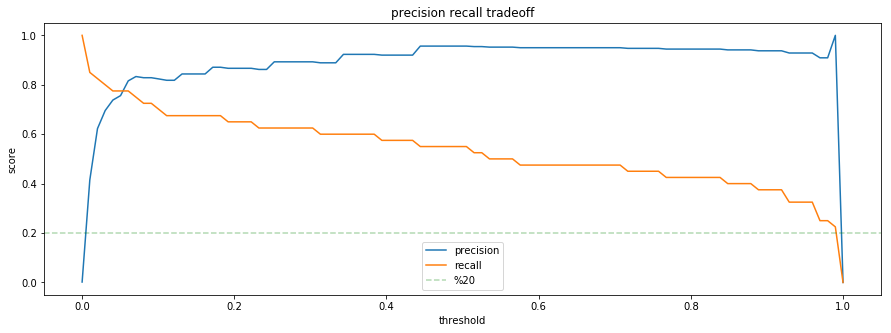

In [39]:
# make plot for logistic regression C=10 with linear PCA transformed data

# set logistic regression parameters
clf = LogisticRegression()

# plot
precision_recall_tradeoff_plot(clf, "original")

It seems like the best threshold would be around 0.05. This way I can reach my goal of %20 precision.

## 2.3 Decision Tree Classifier

Decision Trees work by creating a set of questions. These questions branch off into two or more anwers called "leaves". Each leaf then has its own question and breaks into more leaves, until a certain depth is reached. The model finds its questions by calculation information gain or "entropy". There are two hyper-parameters I will tune for tree based models. One is the max depth, which is the maximum amount of levels allowed in the tree. Lowering this makes the model simpler and can reduce over fitting. The other is minimum leaves per sample, which controls the minimum number of leaves. Increasing this can give the model more potential for learning, but also it can lead to over fitting.

In [32]:
# set the parameter grid 
tree_params = {
    "max_depth": [2, 3, 4, None],
    "min_samples_leaf":[2, 3, 4]
}

# conduct grid search
automated_grid_search(DecisionTreeClassifier(), tree_params)



 lin 


Training F1-Score: 0.9252298615193696
Validation F1-Score: 0.017604818160759785
Best parameters {'max_depth': 4, 'min_samples_leaf': 3}




 lin_pca 


Training F1-Score: 0.9328312552169182
Validation F1-Score: 0.013112365689309778
Best parameters {'max_depth': 3, 'min_samples_leaf': 3}




 tree 


Training F1-Score: 0.9502754074986034
Validation F1-Score: 0.005711279777560682
Best parameters {'max_depth': 2, 'min_samples_leaf': 2}




KeyboardInterrupt: 

The model is over fitting, so I will decrease the max depth parameter and let the minimum samples per leaf be set to the default.

In [ ]:
# set the parameter grid 
tree_params = {
    "max_depth": [2],
}

# conduct grid search
automated_grid_search(DecisionTreeClassifier(), tree_params)

It seems the decision tree classifier will not perform well for this task. Perhaps it will work better on the data that is not engineered. It will take longer to run this way, so a grid search is not feasable. Lets give that a try.

In [33]:
# instantiate decision tree
clf = DecisionTreeClassifier()

# fit 
clf.fit(data["original"]["X_train"], data["original"]["y_train"])

# predict on validation set
predictions = clf.predict(data["original"]["X_val"])

# print classification report
print(classification_report(data["original"]["y_val"], predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24077
           1       0.78      0.78      0.78        40

    accuracy                           1.00     24117
   macro avg       0.89      0.89      0.89     24117
weighted avg       1.00      1.00      1.00     24117



The model seems to be performing much better this way.

## 2.3 Random Forest Classifier

The random forest algorithm is an ensemble algorithm. This means that it is a collection of simpler algorithms working together. A random forest is a collection of decision trees who each cast a "vote" for the prediction. Each tree has to use slightly different features. The random forest algorithm uses decision tree hyper-parameters along with a new one called n-estimators. N-estimators controls how many trees are used and increasing it can decrease overfitting.

In [45]:
# set parameters
tree_params = {
    "max_depth":[2, 3, 4, None],
    "min_samples_leaf":[2, 3],
    "n_estimators":[100, 500]
}

# instantiate random forest classifier
clf = RandomForestClassifier()

# perform grid search
automated_grid_search(clf, tree_params)



 lin 


Training F1-Score: 0.947444477539347
Validation F1-Score: 0.0056809905316824475
Best parameters {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}




 lin_pca 


Training F1-Score: 0.9474811818259202
Validation F1-Score: 0.010826627651792245
Best parameters {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}




 tree 


Training F1-Score: 0.9596000772228778
Validation F1-Score: 0.005201204489460718
Best parameters {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 500}




Again the models are overfitting. I am going to assume that too much data has been lost to the resampling. Lets now test the model on the original data.

In [46]:
# fit classifier
clf.fit(data["original"]["X_train"], data["original"]["y_train"])

# get predictions
predictions = clf.predict(data["original"]["X_val"])

# print classification report
print(classification_report(data["original"]["y_val"], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24077
           1       1.00      0.72      0.84        40

    accuracy                           1.00     24117
   macro avg       1.00      0.86      0.92     24117
weighted avg       1.00      1.00      1.00     24117



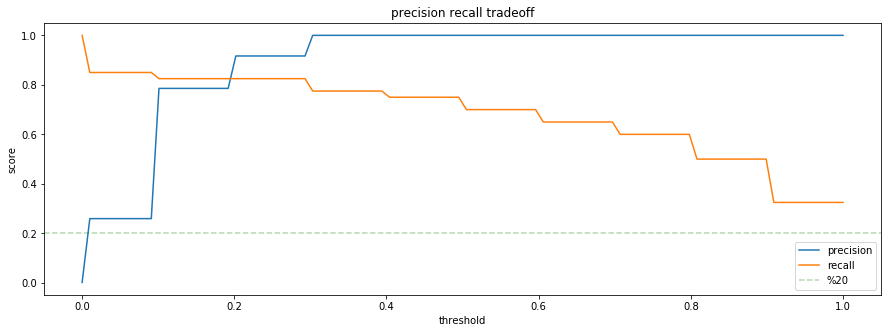

In [47]:
precision_recall_tradeoff_plot(clf, "original")

It seems 0.2 would be a good threshold.

## 2.4 K Nearest Neighbors

K Nearest Neighbors is a distance based algorithm. It simply finds the closest neighbors of the point in question belonging to the training set (using multidimensional space). Then it sees how many neighbors belong to class 1 or class 0 and calculates a probability. The hyper-parameter for this algorithm is the amount of neighbors "K". The higher the amount of neighbors the more regulated the model will be. Meaning with a high "K" value it learns less, but may not over fit as much. Always ensure K is an odd number to avoid having a tie between classes.

In [48]:
# instantiate K neighbors classifier
clf = KNeighborsClassifier(n_neighbors=15)

# fit
clf.fit(data["original"]["X_train"], data["original"]["y_train"])

# get predictions
predictions = clf.predict(data["original"]["X_val"])

# print classification report
print(classification_report(data["original"]["y_val"], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24077
           1       0.94      0.75      0.83        40

    accuracy                           1.00     24117
   macro avg       0.97      0.87      0.92     24117
weighted avg       1.00      1.00      1.00     24117



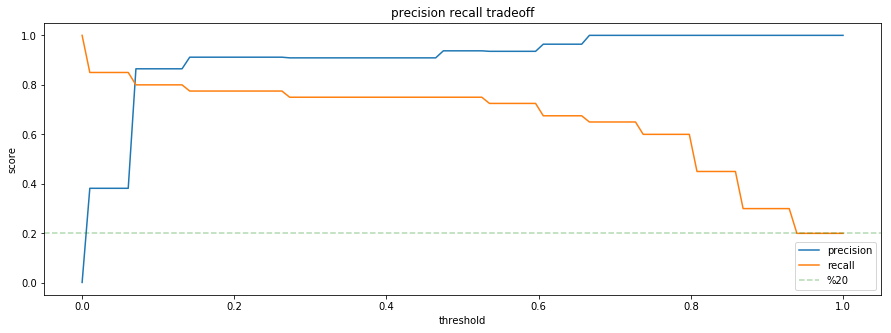

In [49]:
precision_recall_tradeoff_plot(clf, "original")

It seems like a good tradeoff point would be 0.15.

# 3. Compare Results